In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from keijzer import *
import math

In [2]:
data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2020.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
#dat_source1 = dat_source1.iloc[:-3,:]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2021.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:8761,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2022.csv'
data_source3 = pd.read_csv(data_path)
dat_source3 = pd.DataFrame(data_source3)
dat_source3 = dat_source3.iloc[:8760,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2023.csv'
data_source4 = pd.read_csv(data_path)
dat_source4 = pd.DataFrame(data_source4)
dat_source4 = dat_source4.iloc[:8760,:9]

dat_arr1 = np.array(dat_source1)
dat_arr2 = np.array(dat_source2)
dat_arr3 = np.array(dat_source3)
dat_arr4 = np.array(dat_source4)

dat_arr = np.concatenate([dat_arr1, dat_arr2, dat_arr3, dat_arr4],axis=0)
dat_arr.shape # 8784, 8761, 8760, 8760

dat_source = pd.DataFrame(dat_arr, columns=['Time-Date stamp','Date','ERCOT Load','Total Wind Output','Total Wind Installed','Wind Output, % of Load','Wind Output, % of Installed','1-hr MW change','1-hr % change'])
dat_source

,Time-Date stamp,Date,ERCOT Load,Total Wind Output,Total Wind Installed,"Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
35060,12-31-2023 20:00:00,Dec-31,44887,17161,38631,38.23,44.42,2858,19.99
35061,12-31-2023 21:00:00,Dec-31,44013,18301,38631,41.58,47.37,1139,6.64
35062,12-31-2023 22:00:00,Dec-31,43280,18607,38631,42.99,48.17,307,1.67
35063,12-31-2023 23:00:00,Dec-31,42319,17866,38631,42.22,46.25,-741,-3.98


In [3]:
dat = pd.DataFrame()
dat['Timestamp'] = np.array(dat_source['Time-Date stamp'].iloc[1:])
dat['MW % change'] = np.array(dat_source.iloc[1:,3], dtype=float)-np.array(dat_source.iloc[0:-1,3], dtype=float)
dat['MW % change'] = np.divide(np.array(dat['MW % change']),np.array(dat_source.iloc[1:,4]))*100
dat['Total Wind Output'] = np.divide(np.array(dat_source.iloc[1:,3]), np.array(dat_source.iloc[1:,4]))

ramp_ratio = 20
load_ratio = 10
year_arr = np.concatenate([np.ones(8784)*2020, np.ones(8760)*2021, np.ones(8760)*2022, np.ones(8760)*2023])
year_df = pd.DataFrame(year_arr, columns=['Year'], dtype=int)
wind_df = pd.concat([year_df, dat], axis=1)
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35054,2023,12-31-2023 15:00:00,0.906008,0.224535
35055,2023,12-31-2023 16:00:00,1.3383,0.237918
35056,2023,12-31-2023 17:00:00,2.27279,0.260646
35057,2023,12-31-2023 18:00:00,2.26243,0.28327
35058,2023,12-31-2023 19:00:00,8.69768,0.370247
35059,2023,12-31-2023 20:00:00,7.3982,0.444229
35060,2023,12-31-2023 21:00:00,2.951,0.473739
35061,2023,12-31-2023 22:00:00,0.79211,0.48166
35062,2023,12-31-2023 23:00:00,-1.91815,0.462478
35063,2023,01-01-2024 00:00:00,-5.16942,0.410784


In [4]:
import sklearn

wind_df = wind_df.reset_index(drop=True)

std_scaler = sklearn.preprocessing.MinMaxScaler()
std_scaler_load = sklearn.preprocessing.MinMaxScaler()
std_scaler_ramp = sklearn.preprocessing.MinMaxScaler()

wind_df[['Total Wind Output']] = std_scaler.fit_transform(wind_df[['Total Wind Output']])
wind_df[['MW % change']] = std_scaler_ramp.fit_transform(wind_df[['MW % change']])
#wind_df[['Wind Change, % of Load', 'Wind Change']] = std_scaler_ramp.fit_transform(wind_df[['Wind Change, % of Load', 'Wind Change']])
wind_df = wind_df.iloc[:-1,:]
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35053,2023,12-31-2023 14:00:00,0.475470,0.281695
35054,2023,12-31-2023 15:00:00,0.540013,0.293595
35055,2023,12-31-2023 16:00:00,0.553030,0.311174
35056,2023,12-31-2023 17:00:00,0.581170,0.341026
35057,2023,12-31-2023 18:00:00,0.580858,0.370742
35058,2023,12-31-2023 19:00:00,0.774643,0.484984
35059,2023,12-31-2023 20:00:00,0.735512,0.582157
35060,2023,12-31-2023 21:00:00,0.601593,0.620917
35061,2023,12-31-2023 22:00:00,0.536583,0.631322
35062,2023,12-31-2023 23:00:00,0.454969,0.606127


In [5]:
dat_source1

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
8779,12-31-2020 19:00:00,Dec-31,49857,15165,31090,30.4,48.777,788.4,5.484
8780,12-31-2020 20:00:00,Dec-31,48800,15706,31090,32.2,50.517,540.8,3.566
8781,12-31-2020 21:00:00,Dec-31,47848,15079,31090,31.5,48.502,-626.4,-3.989
8782,12-31-2020 22:00:00,Dec-31,46123,14995,31090,32.5,48.231,-84.1,-0.558


In [6]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Final/Basic Daily Forecasting/training_result_dflead.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Final/Basic Daily Forecasting/training_ramp_result_dflead.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

dat_source = pd.concat([dat_source1, dat_source2], axis=1)
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value
0,0.537823,0.582944,0.045120,0.536298,0.358280,0.414383,0.056103,0.375787
1,0.495294,0.537540,0.042246,0.493026,0.358265,0.408637,0.050372,0.343919
2,0.476776,0.488715,0.011939,0.482593,0.375702,0.400791,0.025089,0.300995
3,0.464167,0.456855,-0.007312,0.500272,0.393599,0.439688,0.046089,0.283976
4,0.448673,0.409138,-0.039535,0.488074,0.454168,0.403333,-0.050835,0.423184
...,...,...,...,...,...,...,...,...
748963,0.505955,0.475905,-0.030050,0.495560,0.353517,0.437360,0.083843,0.240323
748964,0.476933,0.464749,-0.012184,0.497707,0.445349,0.487154,0.041804,0.357223
748965,0.403353,0.395094,-0.008258,0.494697,0.341048,0.353038,0.011990,0.376408
748966,0.333824,0.315399,-0.018425,0.491825,0.375074,0.330019,-0.045054,0.325814


In [7]:
pred = np.array(dat_source[['Predicted_Value']])
rpred = np.array(dat_source[['Ramp_Predicted_Value']])

real_value = np.array(dat_source[['Predicted_Value']])+np.array(dat_source[['Forecasting_Error']])
real_ramp_value = np.array(dat_source[['Ramp_Predicted_Value']])+np.array(dat_source[['Ramp_Forecasting_Error']])

dat_source['Real_Value'] = real_value
dat_source['Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Initial_Predicted_Value']])
dat_source['Real_Ramp_Value'] = real_ramp_value
dat_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Ramp_Initial_Predicted_Value']])
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.537823,0.582944,0.045120,0.536298,0.358280,0.414383,0.056103,0.375787,0.046646,0.414383,0.207157
1,0.495294,0.537540,0.042246,0.493026,0.358265,0.408637,0.050372,0.343919,0.044514,0.408637,0.193622
2,0.476776,0.488715,0.011939,0.482593,0.375702,0.400791,0.025089,0.300995,0.006122,0.400791,0.187720
3,0.464167,0.456855,-0.007312,0.500272,0.393599,0.439688,0.046089,0.283976,-0.043417,0.439688,0.172879
4,0.448673,0.409138,-0.039535,0.488074,0.454168,0.403333,-0.050835,0.423184,-0.078936,0.403333,-0.014046
...,...,...,...,...,...,...,...,...,...,...,...
748963,0.505955,0.475905,-0.030050,0.495560,0.353517,0.437360,0.083843,0.240323,-0.019655,0.437360,0.235582
748964,0.476933,0.464749,-0.012184,0.497707,0.445349,0.487154,0.041804,0.357223,-0.032958,0.487154,0.107526
748965,0.403353,0.395094,-0.008258,0.494697,0.341048,0.353038,0.011990,0.376408,-0.099603,0.353038,0.018686
748966,0.333824,0.315399,-0.018425,0.491825,0.375074,0.330019,-0.045054,0.325814,-0.176425,0.330019,-0.010415


In [8]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Final/Basic Daily Forecasting/test_result_dflead.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Final/Basic Daily Forecasting/test_ramp_result_dflead.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

test_source = pd.concat([dat_source1, dat_source2], axis=1)
ini_test_source = pd.DataFrame(test_source)

pred = np.array(test_source[['Predicted_Value']])
rpred = np.array(test_source[['Ramp_Predicted_Value']])

real_value = np.array(test_source[['Predicted_Value']])+np.array(test_source[['Forecasting_Error']])
real_ramp_value = np.array(test_source[['Ramp_Predicted_Value']])+np.array(test_source[['Ramp_Forecasting_Error']])

test_source['Real_Value'] = real_value
test_source['Initial_Forecasting_Error'] = real_value-np.array(test_source[['Initial_Predicted_Value']])
test_source['Real_Ramp_Value'] = real_ramp_value
test_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(test_source[['Ramp_Initial_Predicted_Value']])
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.503680,0.461890,-0.041790,0.477568,0.530219,0.575072,0.044853,0.520559,-0.015678,0.575072,-0.058669
1,0.538970,0.508118,-0.030852,0.475799,0.589365,0.618712,0.029346,0.580246,0.032319,0.618712,-0.072128
2,0.624355,0.560342,-0.064013,0.473172,0.616369,0.632459,0.016090,0.563898,0.087170,0.632459,-0.003556
3,0.639209,0.597191,-0.042018,0.477669,0.585093,0.597212,0.012119,0.503387,0.119522,0.597212,0.093804
4,0.597050,0.557622,-0.039427,0.493358,0.481230,0.422014,-0.059216,0.559234,0.064264,0.422014,-0.001612
...,...,...,...,...,...,...,...,...,...,...,...
79603,0.285722,0.293595,0.007873,0.662631,0.555236,0.540013,-0.015224,0.560537,-0.369036,0.540013,-0.266942
79604,0.319712,0.311174,-0.008538,0.637145,0.567477,0.553030,-0.014447,0.500876,-0.325972,0.553030,-0.189703
79605,0.363822,0.341026,-0.022796,0.626954,0.510017,0.581170,0.071153,0.383980,-0.285929,0.581170,-0.042954
79606,0.403398,0.370742,-0.032656,0.573104,0.524902,0.580858,0.055957,0.336071,-0.202362,0.580858,0.034671


### Plotting Histograms

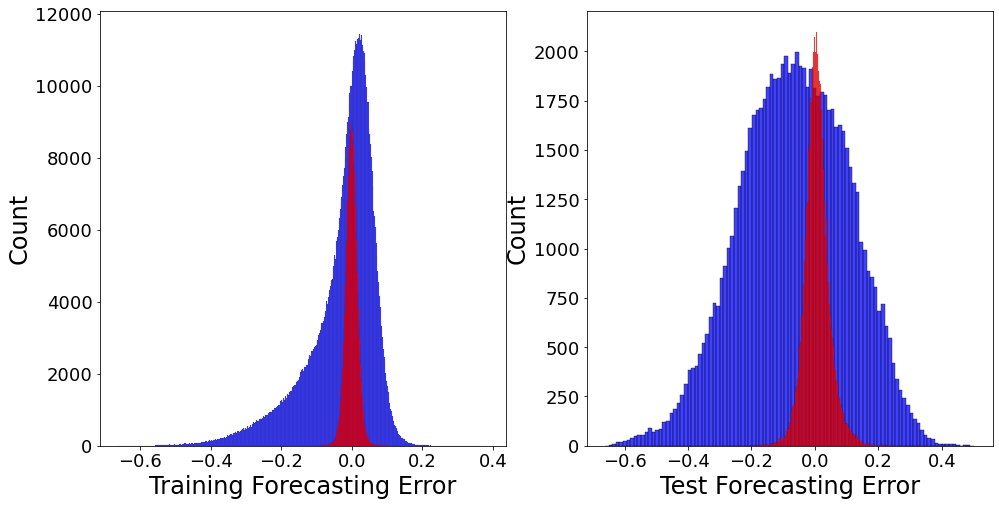

In [9]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

f.savefig('GenError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [10]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

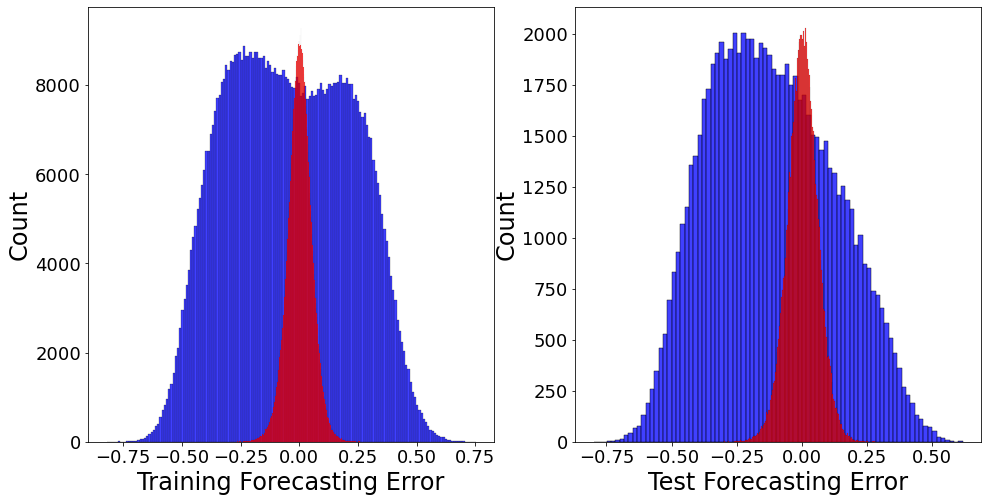

In [11]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Ramp_Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Ramp_Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

f.savefig('RampError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [12]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

## Training/Test Datset Construction

In [9]:
times = np.zeros(dat_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

dat_source['time'] = times
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.537823,0.582944,0.045120,0.536298,0.358280,0.414383,0.056103,0.375787,0.046646,0.414383,0.207157,0
1,0.495294,0.537540,0.042246,0.493026,0.358265,0.408637,0.050372,0.343919,0.044514,0.408637,0.193622,1
2,0.476776,0.488715,0.011939,0.482593,0.375702,0.400791,0.025089,0.300995,0.006122,0.400791,0.187720,2
3,0.464167,0.456855,-0.007312,0.500272,0.393599,0.439688,0.046089,0.283976,-0.043417,0.439688,0.172879,3
4,0.448673,0.409138,-0.039535,0.488074,0.454168,0.403333,-0.050835,0.423184,-0.078936,0.403333,-0.014046,4
...,...,...,...,...,...,...,...,...,...,...,...,...
748963,0.505955,0.475905,-0.030050,0.495560,0.353517,0.437360,0.083843,0.240323,-0.019655,0.437360,0.235582,19
748964,0.476933,0.464749,-0.012184,0.497707,0.445349,0.487154,0.041804,0.357223,-0.032958,0.487154,0.107526,20
748965,0.403353,0.395094,-0.008258,0.494697,0.341048,0.353038,0.011990,0.376408,-0.099603,0.353038,0.018686,21
748966,0.333824,0.315399,-0.018425,0.491825,0.375074,0.330019,-0.045054,0.325814,-0.176425,0.330019,-0.010415,22


In [10]:
times = np.zeros(test_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

test_source['time'] = times
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.503680,0.461890,-0.041790,0.477568,0.530219,0.575072,0.044853,0.520559,-0.015678,0.575072,-0.058669,0
1,0.538970,0.508118,-0.030852,0.475799,0.589365,0.618712,0.029346,0.580246,0.032319,0.618712,-0.072128,1
2,0.624355,0.560342,-0.064013,0.473172,0.616369,0.632459,0.016090,0.563898,0.087170,0.632459,-0.003556,2
3,0.639209,0.597191,-0.042018,0.477669,0.585093,0.597212,0.012119,0.503387,0.119522,0.597212,0.093804,3
4,0.597050,0.557622,-0.039427,0.493358,0.481230,0.422014,-0.059216,0.559234,0.064264,0.422014,-0.001612,4
...,...,...,...,...,...,...,...,...,...,...,...,...
79603,0.285722,0.293595,0.007873,0.662631,0.555236,0.540013,-0.015224,0.560537,-0.369036,0.540013,-0.266942,19
79604,0.319712,0.311174,-0.008538,0.637145,0.567477,0.553030,-0.014447,0.500876,-0.325972,0.553030,-0.189703,20
79605,0.363822,0.341026,-0.022796,0.626954,0.510017,0.581170,0.071153,0.383980,-0.285929,0.581170,-0.042954,21
79606,0.403398,0.370742,-0.032656,0.573104,0.524902,0.580858,0.055957,0.336071,-0.202362,0.580858,0.034671,22


In [11]:
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.537823,0.582944,0.045120,0.536298,0.358280,0.414383,0.056103,0.375787,0.046646,0.414383,0.207157,0
1,0.495294,0.537540,0.042246,0.493026,0.358265,0.408637,0.050372,0.343919,0.044514,0.408637,0.193622,1
2,0.476776,0.488715,0.011939,0.482593,0.375702,0.400791,0.025089,0.300995,0.006122,0.400791,0.187720,2
3,0.464167,0.456855,-0.007312,0.500272,0.393599,0.439688,0.046089,0.283976,-0.043417,0.439688,0.172879,3
4,0.448673,0.409138,-0.039535,0.488074,0.454168,0.403333,-0.050835,0.423184,-0.078936,0.403333,-0.014046,4
...,...,...,...,...,...,...,...,...,...,...,...,...
748963,0.505955,0.475905,-0.030050,0.495560,0.353517,0.437360,0.083843,0.240323,-0.019655,0.437360,0.235582,19
748964,0.476933,0.464749,-0.012184,0.497707,0.445349,0.487154,0.041804,0.357223,-0.032958,0.487154,0.107526,20
748965,0.403353,0.395094,-0.008258,0.494697,0.341048,0.353038,0.011990,0.376408,-0.099603,0.353038,0.018686,21
748966,0.333824,0.315399,-0.018425,0.491825,0.375074,0.330019,-0.045054,0.325814,-0.176425,0.330019,-0.010415,22


In [16]:
pair_ini_source = dat_source[['Initial_Predicted_Value', 'Initial_Forecasting_Error', 'Ramp_Initial_Predicted_Value', 'Ramp_Initial_Forecasting_Error', 'time']]

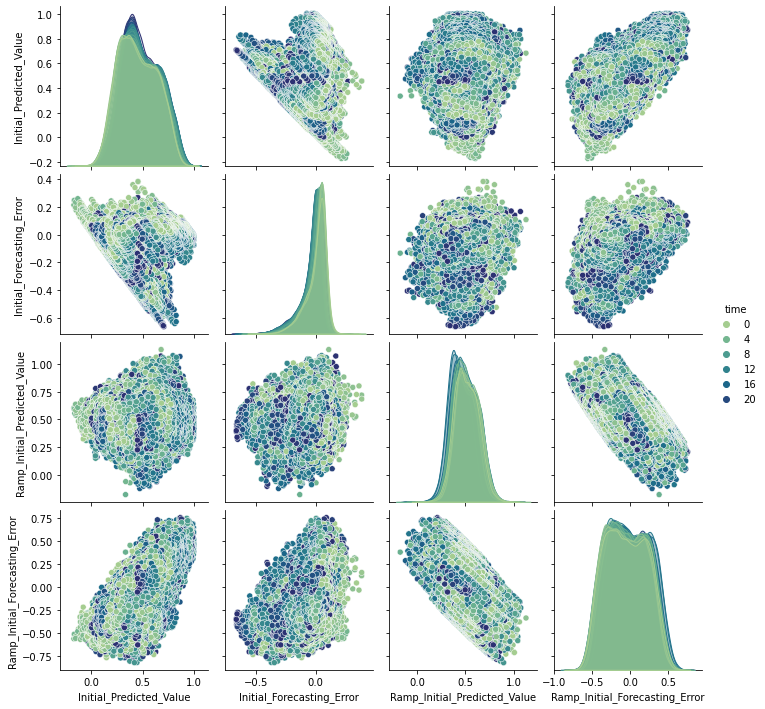

In [17]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_ini_source, palette="crest", hue='time')
plt.savefig('pairplot_ini_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [18]:
pair_source = dat_source[['Predicted_Value', 'Forecasting_Error', 'Ramp_Predicted_Value', 'Ramp_Forecasting_Error', 'time']]

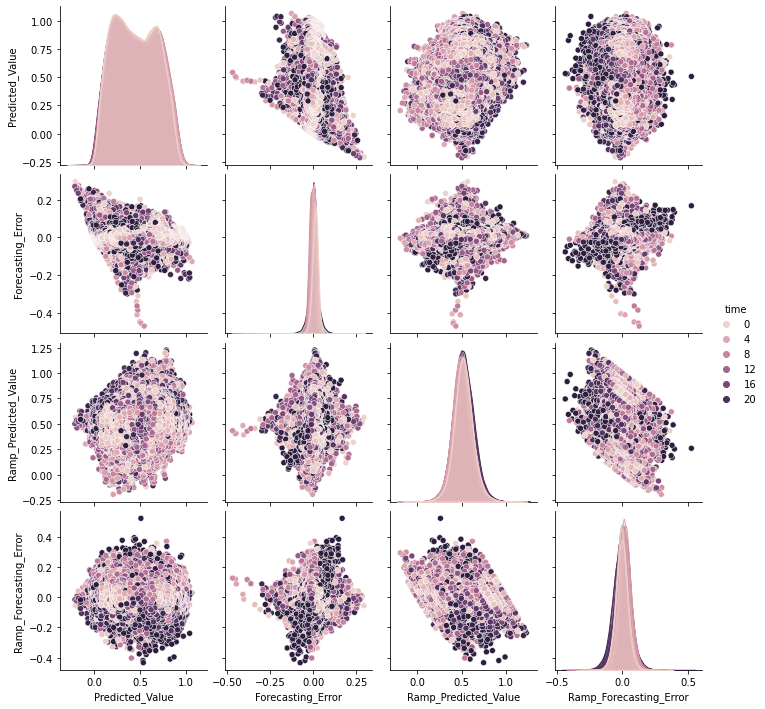

In [19]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_source, hue='time')
plt.savefig('pairplot_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [12]:
def npMAEMS(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true))*100
def npMAEMD(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true-np.mean(y_true)))*100
def npMSE(y_true, y_pred):
    return np.mean(np.square(-y_true+y_pred))
def npMAE(y_true, y_pred):
    return np.mean(abs(-y_true+y_pred))

In [13]:
tr_source = pd.DataFrame()
tr_source['Predicted_Value'] = dat_source['Predicted_Value']
tr_source['Real_Value'] = dat_source['Predicted_Value']+dat_source['Forecasting_Error']
tr_source['Ramp_Predicted_Value'] = dat_source['Ramp_Predicted_Value']
tr_source['Ramp_Real_Value'] = dat_source['Ramp_Predicted_Value']+dat_source['Ramp_Forecasting_Error']

times = np.zeros(tr_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

tr_source['time'] = times
normtr_source = np.array(tr_source)
normtr_source

array([[ 0.53782338,  0.58294372,  0.35828012,  0.41438308,  0.        ],
       [ 0.4952938 ,  0.53754027,  0.35826546,  0.40863697,  1.        ],
       [ 0.47677559,  0.48871469,  0.37570226,  0.40079132,  2.        ],
       ...,
       [ 0.40335274,  0.39509437,  0.34104764,  0.35303773, 21.        ],
       [ 0.33382386,  0.31539923,  0.37507352,  0.33001903, 22.        ],
       [ 0.29019028,  0.25829484,  0.41132009,  0.38181111, 23.        ]])

In [14]:
tr_source[['Predicted_Value']] = std_scaler.inverse_transform(tr_source[['Predicted_Value']])
tr_source[['Real_Value']] = std_scaler.inverse_transform(tr_source[['Real_Value']])

tr_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Predicted_Value']])
tr_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Real_Value']])
tr_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.410476,0.444828,-5.129020,-3.265935,0
1,0.378096,0.410260,-5.129507,-3.456754,1
2,0.363997,0.373087,-4.550460,-3.717295,2
3,0.354398,0.348831,-3.956141,-2.425599,3
4,0.342602,0.312502,-1.944753,-3.632894,4
...,...,...,...,...,...
748963,0.386213,0.363335,-5.287199,-2.502920,19
748964,0.364117,0.354841,-2.237593,-0.849347,20
748965,0.308098,0.301810,-5.701281,-5.303111,21
748966,0.255162,0.241135,-4.571339,-6.067523,22


In [15]:
trgen_pred = np.array(tr_source['Predicted_Value']).reshape(-1,24)
trgen_real = np.array(tr_source['Real_Value']).reshape(-1,24)
trram_pred = np.array(tr_source['Ramp_Predicted_Value']).reshape(-1,24)
trram_real = np.array(tr_source['Ramp_Real_Value']).reshape(-1,24)

trng_pred = np.array(normtr_source[:,0]).reshape(-1,24)
trnr_pred = np.array(normtr_source[:,2]).reshape(-1,24)

In [16]:
tgram = np.zeros(trgen_pred.shape)

for i in range(tgram.shape[0]):
    for j in range(tgram.shape[1]):
        if (i==0) & (j==0):
            gen0 = trgen_real[0,0]-trram_real[0,0]/100
        elif j==0:
            gen0 = trgen_real[i-1,0]
        else:
            gen0 = trgen_pred[i,j-1]
        
        tgram[i,j] = (trgen_pred[i,j]-gen0)*100

### Reconstruction of Original Dataset

In [17]:
t_source = pd.DataFrame()

In [18]:
t_source['Predicted_Value'] = ini_test_source['Predicted_Value']
t_source['Real_Value'] = ini_test_source['Predicted_Value']+ini_test_source['Forecasting_Error']
t_source['Ramp_Predicted_Value'] = ini_test_source['Ramp_Predicted_Value']
t_source['Ramp_Real_Value'] = ini_test_source['Ramp_Predicted_Value']+ini_test_source['Ramp_Forecasting_Error']

times = np.zeros(ini_test_source.shape[0])
for i in range(times.shape[0]):
    times[i] = int(i%24)

t_source['time'] = times

In [19]:
normt_source = np.array(t_source)
normt_source

array([[ 0.50368011,  0.46189047,  0.53021884,  0.57507233,  0.        ],
       [ 0.53896981,  0.50811783,  0.58936548,  0.61871195,  1.        ],
       [ 0.62435496,  0.56034151,  0.61636943,  0.63245924,  2.        ],
       ...,
       [ 0.3638224 ,  0.34102591,  0.5100174 ,  0.58117028, 21.        ],
       [ 0.40339828,  0.37074228,  0.52490163,  0.58085847, 22.        ],
       [ 0.44011271,  0.48498374,  0.62571818,  0.77464268, 23.        ]])

In [20]:
t_source[['Predicted_Value']] = std_scaler.inverse_transform(t_source[['Predicted_Value']])
t_source[['Real_Value']] = std_scaler.inverse_transform(t_source[['Real_Value']])

t_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Predicted_Value']])
t_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Real_Value']])
t_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.384481,0.352665,0.580775,2.070283,0.0
1,0.411349,0.387860,2.544935,3.519482,1.0
2,0.476356,0.427620,3.441691,3.976006,2.0
3,0.487665,0.455675,2.403054,2.805500,3.0
4,0.455567,0.425549,-1.046065,-3.012528,4.0
...,...,...,...,...,...
79603,0.218540,0.224535,1.411564,0.906008,19.0
79604,0.244418,0.237918,1.818051,1.338303,20.0
79605,0.278002,0.260646,-0.090081,2.272786,21.0
79606,0.308132,0.283270,0.404199,2.262432,22.0


## Combination of Two Forecasting Results - Training Set

In [21]:
gen_pred = np.array(tr_source['Predicted_Value']).reshape(-1,24)
gen_real = np.array(tr_source['Real_Value']).reshape(-1,24)
ram_pred = np.array(tr_source['Ramp_Predicted_Value']).reshape(-1,24)
ram_real = np.array(tr_source['Ramp_Real_Value']).reshape(-1,24)

ng_pred = np.array(normtr_source[:,0]).reshape(-1,24)
nr_pred = np.array(normtr_source[:,2]).reshape(-1,24)

f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

In [22]:
f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

for i in range(gen_pred.shape[0]):    
    for j in range(gen_pred.shape[1]):
        if (i==0) & (j==0):
            gen0 = gen_real[0,0]-ram_real[0,0]/100
            
        elif j==0:
            gen0 = gen_real[i-1,0]
            
        else:
            gen0 = f_gen[i,j-1]
        
        if ((nr_pred[i,j]<0.2)) | ((nr_pred[i,j]>0.8)):
            rind = 1
        else:
            rind = 0

        if ((ng_pred[i,j]>0.8)):
            gind = 1
        else:
            gind = 0
            
            
        a = 2/3
        b = 1-a
        
        if gind == 1:
            f_gen[i,j] = gen_pred[i,j]
            f_ram[i,j] = (f_gen[i,j]-gen0)*100
        elif rind == 1:
            f_gen[i,j] = gen0 + ram_pred[i,j]/100
            f_ram[i,j] = ram_pred[i,j]
        else:
            f_gen[i,j] = gen0 + (gen_pred[i,j]-gen0)*a + ram_pred[i,j]/100*b
            f_ram[i,j] = (f_gen[i,j]-gen0)*100

In [23]:
real_gen = np.array(tr_source[['Real_Value']])
real_ram = np.array(tr_source[['Ramp_Real_Value']])

gen_only = np.array(tr_source[['Predicted_Value']])
ram_only = np.array(tr_source[['Ramp_Predicted_Value']])

com_gen = f_gen.reshape(-1,1)
com_ram = f_ram.reshape(-1,1)

In [24]:
real_gen = std_scaler.transform(real_gen)
gen_only = std_scaler.transform(gen_only)
com_gen = std_scaler.transform(com_gen)

In [25]:
real_ram = std_scaler_ramp.transform(real_ram)
ram_only = std_scaler_ramp.transform(ram_only)
com_ram = std_scaler_ramp.transform(com_ram)

In [26]:
print('Generation Only Error Test Score > MSE == ', npMSE(real_gen, gen_only), ' MAE == ', npMAE(real_gen, gen_only), ' MAEMS == ', npMAEMS(real_gen, gen_only), ' MAEMD == ', npMAEMD(real_gen, gen_only))
print('Combined Generation Error Test Score > MSE == ', npMSE(real_gen, com_gen), ' MAE == ', npMAE(real_gen, com_gen), ' MAEMS == ', npMAEMS(real_gen, com_gen), ' MAEMD == ', npMAEMD(real_gen, com_gen))
print('Ramp Rate Only Error Test Score > MSE == ', npMSE(real_ram, ram_only), ' MAE == ', npMAE(real_ram, ram_only), ' MAEMS == ', npMAEMS(real_ram, ram_only), ' MAEMD == ', npMAEMD(real_ram, ram_only))
print('Combined Ramp Rate Error Test Score > MSE == ', npMSE(real_ram, com_ram), ' MAE == ', npMAE(real_ram, com_ram), ' MAEMS == ', npMAEMS(real_ram, com_ram), ' MAEMD == ', npMAEMD(real_ram, com_ram))

Generation Only Error Test Score > MSE ==  0.00030864555850890636  MAE ==  0.0128807562080741  MAEMS ==  0.2977144352919331  MAEMD ==  0.07293853196482211
Combined Generation Error Test Score > MSE ==  0.0003757997807712828  MAE ==  0.014240148209254847  MAEMS ==  0.33413384321451695  MAEMD ==  0.07857166577925258
Ramp Rate Only Error Test Score > MSE ==  0.0028489586551192327  MAE ==  0.041770756515306165  MAEMS ==  1.1424604528767868  MAEMD ==  0.04488656009421099
Combined Ramp Rate Error Test Score > MSE ==  0.0008661896672782333  MAE ==  0.021360938758325218  MAEMS ==  0.5878463855855535  MAEMD ==  0.02921067951059849


In [27]:
final = np.concatenate([com_gen, real_gen, com_ram, real_ram], axis=1)

In [28]:
final = pd.DataFrame(final, columns=['Predicted Generation','Real Generation','Predicted Ramp','Real Ramp'])
final.to_csv('Combined_training_result_df_lead.csv')

## Combination of Two Forecasting Results - Test Set

In [29]:
gen_pred = np.array(t_source['Predicted_Value']).reshape(-1,24)
gen_real = np.array(t_source['Real_Value']).reshape(-1,24)
ram_pred = np.array(t_source['Ramp_Predicted_Value']).reshape(-1,24)
ram_real = np.array(t_source['Ramp_Real_Value']).reshape(-1,24)

ng_pred = np.array(normt_source[:,0]).reshape(-1,24)
nr_pred = np.array(normt_source[:,2]).reshape(-1,24)

f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

In [30]:
f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

for i in range(gen_pred.shape[0]):    
    for j in range(gen_pred.shape[1]):
        if (i==0) & (j==0):
            gen0 = gen_real[0,0]-ram_real[0,0]/100
            
        elif j==0:
            gen0 = gen_real[i-1,0]
            
        else:
            gen0 = f_gen[i,j-1]
        
        if ((nr_pred[i,j]<0.2)) | ((nr_pred[i,j]>0.8)):
            rind = 1
        else:
            rind = 0

        if ((ng_pred[i,j]>0.8)):
            gind = 1
        else:
            gind = 0
            
            
        a = 2/3
        b = 1-a
        
        if gind == 1:
            f_gen[i,j] = gen_pred[i,j]
            f_ram[i,j] = (f_gen[i,j]-gen0)*100
        elif rind == 1:
            f_gen[i,j] = gen0 + ram_pred[i,j]/100
            f_ram[i,j] = ram_pred[i,j]
        else:
            f_gen[i,j] = gen0 + (gen_pred[i,j]-gen0)*a + ram_pred[i,j]/100*b
            f_ram[i,j] = (f_gen[i,j]-gen0)*100

In [31]:
real_gen = np.array(t_source[['Real_Value']])
real_ram = np.array(t_source[['Ramp_Real_Value']])

gen_only = np.array(t_source[['Predicted_Value']])
ram_only = np.array(t_source[['Ramp_Predicted_Value']])

com_gen = f_gen.reshape(-1,1)
com_ram = f_ram.reshape(-1,1)

In [32]:
real_gen = std_scaler.transform(real_gen)
gen_only = std_scaler.transform(gen_only)
com_gen = std_scaler.transform(com_gen)

In [33]:
real_ram = std_scaler_ramp.transform(real_ram)
ram_only = std_scaler_ramp.transform(ram_only)
com_ram = std_scaler_ramp.transform(com_ram)

In [34]:
print('Generation Only Error Test Score > MSE == ', npMSE(real_gen, gen_only), ' MAE == ', npMAE(real_gen, gen_only), ' MAEMS == ', npMAEMS(real_gen, gen_only), ' MAEMD == ', npMAEMD(real_gen, gen_only))
print('Combined Generation Error Test Score > MSE == ', npMSE(real_gen, com_gen), ' MAE == ', npMAE(real_gen, com_gen), ' MAEMS == ', npMAEMS(real_gen, com_gen), ' MAEMD == ', npMAEMD(real_gen, com_gen))
print('Ramp Rate Only Error Test Score > MSE == ', npMSE(real_ram, ram_only), ' MAE == ', npMAE(real_ram, ram_only), ' MAEMS == ', npMAEMS(real_ram, ram_only), ' MAEMD == ', npMAEMD(real_ram, ram_only))
print('Combined Ramp Rate Error Test Score > MSE == ', npMSE(real_ram, com_ram), ' MAE == ', npMAE(real_ram, com_ram), ' MAEMS == ', npMAEMS(real_ram, com_ram), ' MAEMD == ', npMAEMD(real_ram, com_ram))

Generation Only Error Test Score > MSE ==  0.0010769692992615974  MAE ==  0.024615836419590656  MAEMS ==  0.5133157600707815  MAEMD ==  0.12111484001898745
Combined Generation Error Test Score > MSE ==  0.0010854619347028603  MAE ==  0.024728899261660605  MAEMS ==  0.5192855513134855  MAEMD ==  0.12236031858030524
Ramp Rate Only Error Test Score > MSE ==  0.0029517176625286122  MAE ==  0.04264055516701  MAEMS ==  1.1627979027907183  MAEMD ==  0.04051674079045567
Combined Ramp Rate Error Test Score > MSE ==  0.0014114407467156662  MAE ==  0.028109000933338072  MAEMS ==  0.7676857683097862  MAEMD ==  0.030621689605856782


In [42]:
real_gen2 = real_gen[(real_gen>0.8)]
gen_only2 = gen_only[(real_gen>0.8)]
com_gen2 = com_gen[(real_gen>0.8)]

In [43]:
real_ram2 = real_ram[(real_ram>0.8)|(real_ram<0.2)]
ram_only2 = ram_only[(real_ram>0.8)|(real_ram<0.2)]
com_ram2 = com_ram[(real_ram>0.8)|(real_ram<0.2)]

In [44]:
print('Generation Only Error Test Score > MSE == ', npMSE(real_gen2, gen_only2), ' MAE == ', npMAE(real_gen2, gen_only2), ' MAEMS == ', npMAEMS(real_gen2, gen_only2), ' MAEMD == ', npMAEMD(real_gen2, gen_only2))
print('Combined Generation Error Test Score > MSE == ', npMSE(real_gen2, com_gen2), ' MAE == ', npMAE(real_gen2, com_gen2), ' MAEMS == ', npMAEMS(real_gen2, com_gen2), ' MAEMD == ', npMAEMD(real_gen2, com_gen2))
print('Ramp Rate Only Error Test Score > MSE == ', npMSE(real_ram2, ram_only2), ' MAE == ', npMAE(real_ram2, ram_only2), ' MAEMS == ', npMAEMS(real_ram2, ram_only2), ' MAEMD == ', npMAEMD(real_ram2, ram_only2))
print('Combined Ramp Rate Error Test Score > MSE == ', npMSE(real_ram2, com_ram2), ' MAE == ', npMAE(real_ram2, com_ram2), ' MAEMS == ', npMAEMS(real_ram2, com_ram2), ' MAEMD == ', npMAEMD(real_ram2, com_ram2))

Generation Only Error Test Score > MSE ==  0.0025708001867141093  MAE ==  0.039898005207424266  MAEMS ==  2.6721343726628564  MAEMD ==  0.001519074445864463
Combined Generation Error Test Score > MSE ==  0.002452179095142691  MAE ==  0.03895990598702769  MAEMS ==  2.609595220654295  MAEMD ==  0.0014866336661160042
Ramp Rate Only Error Test Score > MSE ==  0.004121073805425617  MAE ==  0.049193761716456404  MAEMS ==  2.911667786177511  MAEMD ==  0.30957172181682846
Combined Ramp Rate Error Test Score > MSE ==  0.003009089381781061  MAE ==  0.03933376184102643  MAEMS ==  2.2822516853231187  MAEMD ==  0.26954385072864023


In [37]:
final = np.concatenate([com_gen, real_gen, com_ram, real_ram], axis=1)

In [38]:
final = pd.DataFrame(final, columns=['Predicted Generation','Real Generation','Predicted Ramp','Real Ramp'])
final.to_csv('Combined_result_df_lead.csv')

In [39]:
final

,Predicted Generation,Real Generation,Predicted Ramp,Real Ramp
0,0.483229,0.461890,0.623993,0.575072
1,0.531532,0.508118,0.623471,0.618712
2,0.608482,0.560342,0.689149,0.632459
3,0.639488,0.597191,0.583813,0.597212
4,0.606616,0.557622,0.437367,0.422014
...,...,...,...,...
79603,0.293043,0.293595,0.521670,0.540013
79604,0.318782,0.311174,0.571740,0.553030
79605,0.348414,0.341026,0.580667,0.581170
79606,0.386840,0.370742,0.600825,0.580858


In [40]:
dt1 = pd.DataFrame(np.concatenate([real_gen-gen_only, real_ram-ram_only], axis=1), columns=['er1', 'er2'])
dt2 = pd.DataFrame(np.concatenate([real_gen-com_gen, real_ram-com_ram], axis=1), columns=['er1', 'er2'])

### Comparison of the proposed method and the case when the generation forecasting is only adopted

In [51]:
gentoram = np.zeros(gen_pred.shape)

for i in range(gentoram.shape[0]):
    for j in range(gentoram.shape[1]):
        if j==0:
            if i==0:
                gen0 = gen_real[0,0]-ram_real[0,0]/100
            else:
                gen0 = gen_real[i-1,0]   
        else:
            gen0 = gen_pred[i,j-1]
            
        gentoram[i,j] = (gen_pred[i,j]-gen0)*100
        
gentoram = gentoram.reshape(-1,1)

In [52]:
gentoram = std_scaler_ramp.transform(gentoram)

In [53]:
print('Ramp Rate Only Error Test Score > MSE == ', npMSE(real_ram, ram_only), ' MAE == ', npMAE(real_ram, ram_only), ' MAEMS == ', npMAEMS(real_ram, ram_only))
print('Interpreted From Generation Forecasting Test Score > MSE == ', npMSE(real_ram, gentoram), ' MAE == ', npMAE(real_ram, gentoram), ' MAEMS == ', npMAEMS(real_ram, gentoram))
print('Combined Ramp Rate Error Test Score > MSE == ', npMSE(real_ram, com_ram), ' MAE == ', npMAE(real_ram, com_ram), ' MAEMS == ', npMAEMS(real_ram, com_ram))

Ramp Rate Only Error Test Score > MSE ==  0.003498103541176255  MAE ==  0.046247745678010294  MAEMS ==  1.2648822375921311
Interpreted From Generation Forecasting Test Score > MSE ==  0.003919429835245223  MAE ==  0.045069233018482105  MAEMS ==  1.2248953606327126
Combined Ramp Rate Error Test Score > MSE ==  0.001999712229485605  MAE ==  0.03234546810450945  MAEMS ==  0.8870145820612072


In [54]:
gentoram2 = gentoram[(real_ram>0.8)|(real_ram<0.2)]

In [55]:
print('Ramp Rate Only Error Test Score > MSE == ', npMSE(real_ram2, ram_only2), ' MAE == ', npMAE(real_ram2, ram_only2), ' MAEMD == ', npMAEMD(real_ram2, ram_only2))
print('Interpreted From Generation Forecasting Test Score > MSE == ', npMSE(real_ram2, gentoram2), ' MAE == ', npMAE(real_ram2, gentoram2), ' MAEMD == ', npMAEMD(real_ram2, gentoram2))
print('Combined Ramp Rate Error Test Score > MSE == ', npMSE(real_ram2, com_ram2), ' MAE == ', npMAE(real_ram2, com_ram2), ' MAEMD == ', npMAEMD(real_ram2, com_ram2))

Ramp Rate Only Error Test Score > MSE ==  0.006370561566657005  MAE ==  0.061113111559581615  MAEMD ==  0.4138192944868199
Interpreted From Generation Forecasting Test Score > MSE ==  0.008362673518592023  MAE ==  0.06648611634253151  MAEMD ==  0.547796437845502
Combined Ramp Rate Error Test Score > MSE ==  0.004594374346291147  MAE ==  0.046983999194539265  MAEMD ==  0.363446572819443
